__DD:__ I got an error and found that I needed to install pandas datareader from Environments in Anaconda Navigator. I also upgraded to the latest Pandas version.  

Also noted many future warnings etc. I compared output's to original provided from 2ds and found almost everything matched with minor exceptions.

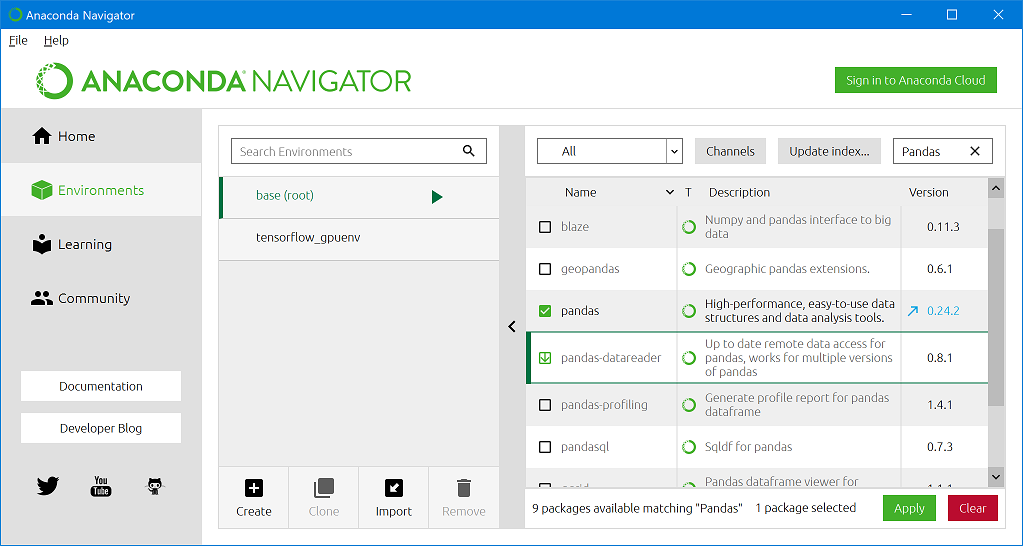

In [1]:
from IPython.display import Image
Image(filename='PandasDataReaderInstall.png') 

__DD:__ Change to your local filesystem.

In [2]:
import os
os.chdir('C:/Users/danie/Documents/GitHub/Quantifying-The-World/Case Study 4')

In [3]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

__DD__ Dickey Fuller test function.

In [4]:
#__DD__ Dickey Fuller Test function
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


## Stock Prices with ARIMA for Gilead Sciences, Inc. (GILD)

In [5]:
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as web
start = datetime.datetime(2015, 10, 1)
end = datetime.datetime(2020, 2, 1)
# Change 'iex' to 'yahoo' and capitalize 'close'
price = web.DataReader('GILD', 'yahoo', start, end)['Close']
price.index = pd.to_datetime(price.index)

__DD__ The data is daily but there are missing dates (Weekends and probably holidays)

In [6]:
price.head()

Date
2015-10-01     98.269997
2015-10-02     98.279999
2015-10-05     99.260002
2015-10-06     97.540001
2015-10-07    100.269997
Name: Close, dtype: float64

__DD__ Reindex to account for missing days and fill with the most recent value:

In [7]:
#__DD:__ Reindex to account for missing days and fill with the most recent value:
idx = pd.date_range('10-01-2015', '2-1-2020')
price = price.reindex(idx, fill_value=None)
price = price.fillna(method='pad')

__DD__ output to .csv so we can try in R as well

In [8]:
#__DD__ output to .csv so we can try in R as well
price.to_csv('price.csv')

C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


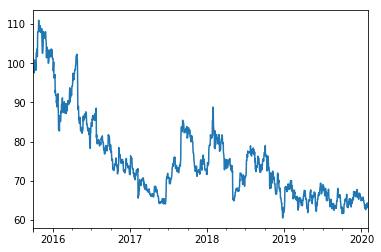

In [9]:
price.plot()

__DD__ We clearly have positive autocorrelation. We probably need high order differencing:

Text(0.5, 1.0, 'Autocorrelation Function')

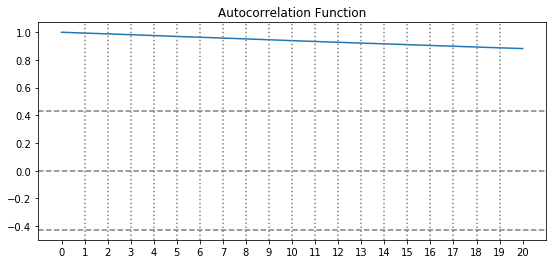

In [10]:
# __DD__ We have positive autocorrelation. 
#We probably need high order differencing:

acf_stock_plot = acf(price, nlags=20, fft=True)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_stock_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

__DD__ Partial autocorrelation: We see a sharp cutoff at lag 1. Also lag 1 is postitive (Rule 6):

Text(0.5, 1.0, 'Partial Autocorrelation Function')

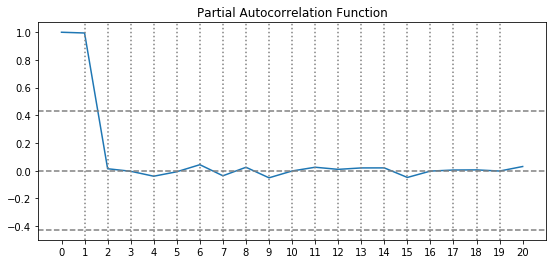

In [11]:
# __DD__ Partial autocorrelation enforces that we probably need high order differencing:

pacf_stock_plot = pacf(price, nlags=20)
#Plot PACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_stock_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pacf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pacf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

__DD__ Perform manual differencing

In [12]:
#__DD__ Perform differencing
diff=price-price.shift()
diff.dropna(inplace=True)

__DD__ Replot after differencing

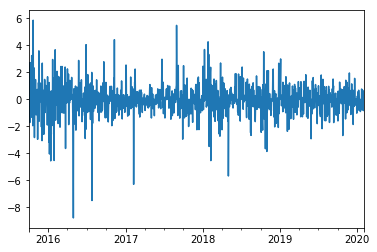

In [13]:
#__DD__ Replot after differencing
diff.plot()

__DD__ Autocorrelation after differencing. Lag 1 is now near 0

Text(0.5, 1.0, 'Autocorrelation Function')

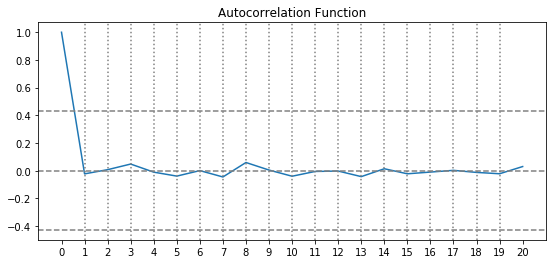

In [14]:
# __DD__ Autocorrelation after differencing

acf_stock_plot = acf(diff, nlags=20, fft=True)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_stock_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

__DD__ Partial Autocorrelation after differencing. Lag 1 near 0

Text(0.5, 1.0, 'Partial Autocorrelation Function')

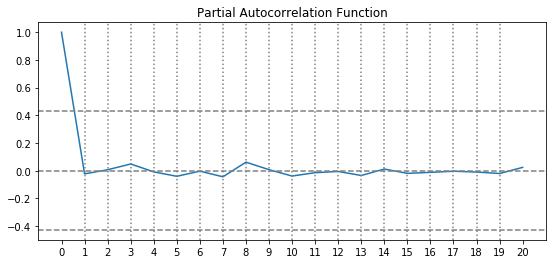

In [15]:
#__DD__ Partial Autocorrelation after differencing
pacf_stock_plot = pacf(diff, nlags=20)
#Plot PACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_stock_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(pacf_stock_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(pacf_stock_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

__DD__ Dickey Fuller test before differencing. Note that our test statistic (-2.436612) is greater than our critical value.(-2.863376 at 5%)

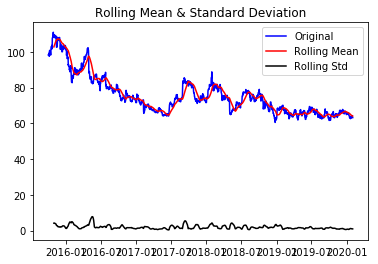

Results of Dickey-Fuller Test:
Test Statistic                   -2.436612
p-value                           0.131669
#Lags Used                        8.000000
Number of Observations Used    1576.000000
Critical Value (1%)              -3.434506
Critical Value (5%)              -2.863376
Critical Value (10%)             -2.567747
dtype: float64


In [16]:
#__DD__ Dickey Fuller test pre differencing
test_stationarity(price)

__DD__ Dickey Fuller test after differencing. The p value is now significant. And Our test statistic (-1.389030e+01) is greater than our critical value.(-2.863376e+00 at 5%).

__DD__ Note that there is some narrowing of the spread: we may want to re-visit this denpending on the accuracy of the final model. (log transform? sqrt?)

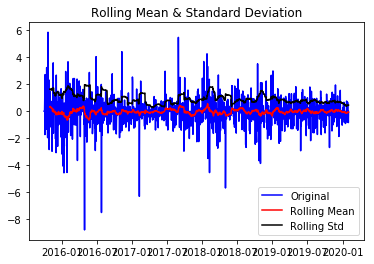

Results of Dickey-Fuller Test:
Test Statistic                -1.389030e+01
p-value                        5.984748e-26
#Lags Used                     7.000000e+00
Number of Observations Used    1.576000e+03
Critical Value (1%)           -3.434506e+00
Critical Value (5%)           -2.863376e+00
Critical Value (10%)          -2.567747e+00
dtype: float64


In [17]:
#__DD__ Dickey Fuller test after differencing
test_stationarity(diff)

__AutoRegressive__
We definitly have dependance on the past therefore we are at minimum p=1. It is also very likely that we are dependent of more than 1 lag, since intuitively when stocks are trending up or downward investors react to it. Selling or buying the stock presumably affects the price at closing. 
Furthermore our partial autocorrelation plot shows a sharp cutoff and lag 1 and is postitive (Rule 6):With that said we can assume at least p=2.

__Difference__
Intuition tells us that if the price of a stock is volatile over time some may be discouraged from buying, (or perhaps encouraged if looking for a quick buck).   
We also see a downward trend in the plot of the data.  
Furthermore our Dickey Fuller test tells us that we are not stationary. Our test statistic (-2.263735) is greater than our critical value.(-2.864195 at 5%).
With this we assume that at minimum use 1 differencing.
We can also see a time varying trend i.e. the spread decreases over time. As per rule # 4 (time varying trend) we will assume that at least 1 additional order of differencing therefore we will make d=2  

__Moving Average__
The moving average also intuitively has an influence on the stock price but if we have p=2 then we probably do not want q to cancel it out (Rule 8). For now we will make q=1 based on rule of thumb.

__Conclusion:__ p=2, d=2, q=1

C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1583
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -2250.698
Method:                       css-mle   S.D. of innovations              1.001
Date:                Sun, 01 Mar 2020   AIC                           4511.396
Time:                        14:33:24   BIC                           4538.231
Sample:                    10-03-2015   HQIC                          4521.366
                         - 02-01-2020                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.552e-05   5.42e-05      0.471      0.638   -8.07e-05       0.000
ar.L1.D2.Close    -0.0222      0.025     -0.883      0.377      -0.071       0.027
ar.L2.D2.Close     0.0073      0.025

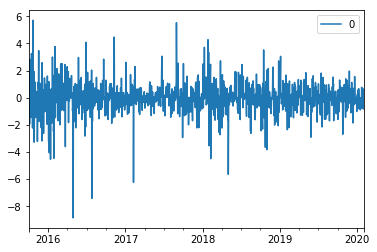

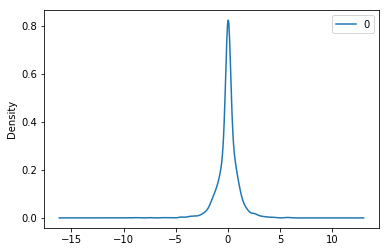

                 0
count  1583.000000
mean     -0.008662
std       1.004476
min      -8.864898
25%      -0.304760
50%       0.020940
75%       0.339486
max       5.710665


In [18]:
#Raw (not manually differenced) data.
model = ARIMA(price, order=(2,2,1), freq=None)
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1584
Model:                     ARMA(2, 1)   Log Likelihood               -2247.739
Method:                       css-mle   S.D. of innovations              1.000
Date:                Sun, 01 Mar 2020   AIC                           4505.478
Time:                        14:33:37   BIC                           4532.316
Sample:                    10-02-2015   HQIC                          4515.449
                         - 02-01-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0222      0.025     -0.872      0.383      -0.072       0.028
ar.L1.Close     0.4229      0.412      1.027      0.305      -0.384       1.230
ar.L2.Close     0.0284      0.026      1.107    

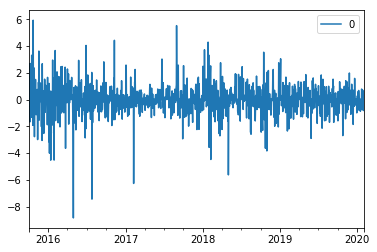

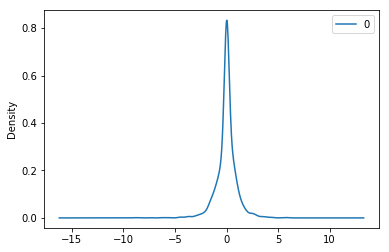

                 0
count  1584.000000
mean     -0.000004
std       1.000404
min      -8.834846
25%      -0.288114
50%       0.022902
75%       0.344307
max       5.921022


In [19]:
#Manually Differenced
model = ARIMA(diff, order=(2,0,1), freq=None)
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

39.82165234099377


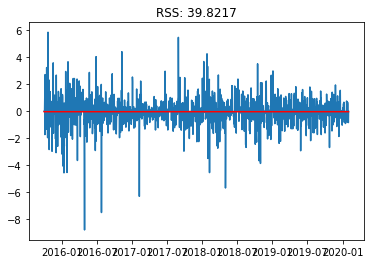

0 0 0
39.81141979043436


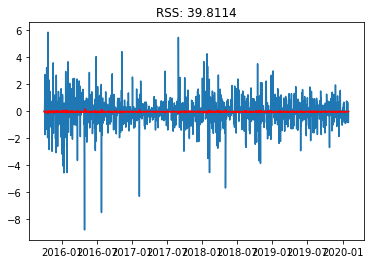

0 0 1
39.80954188371669


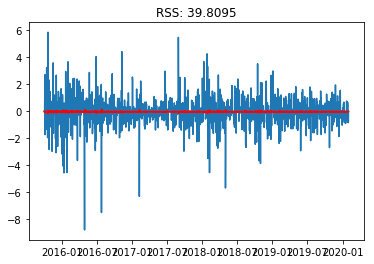

0 0 2


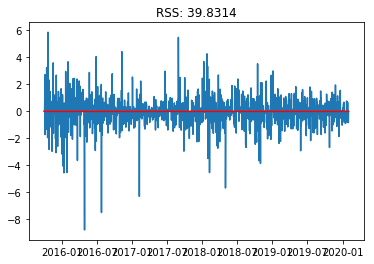

0 1 0


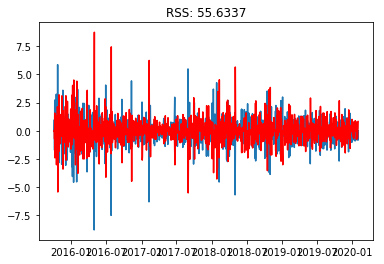

0 1 1


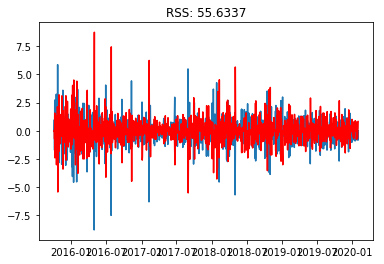

0 1 2


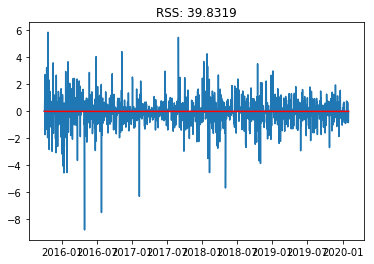

0 2 0


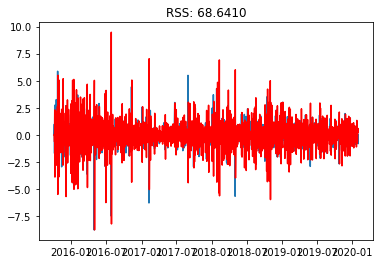

0 2 1


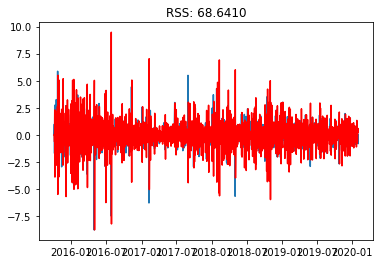

0 2 2


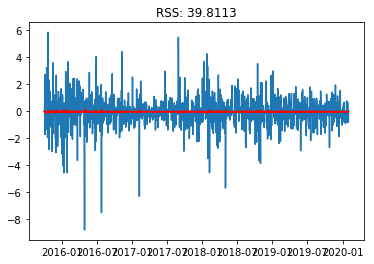

1 0 0


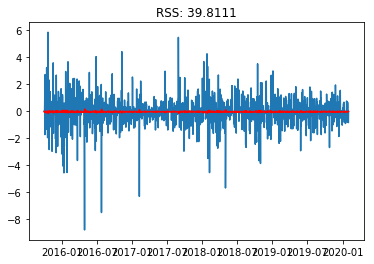

1 0 1


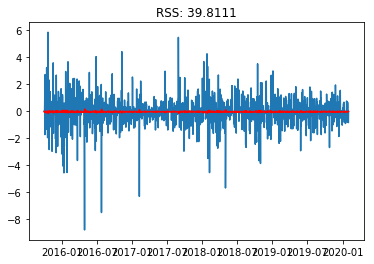

1 0 2


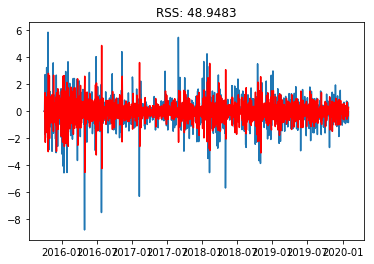

1 1 0


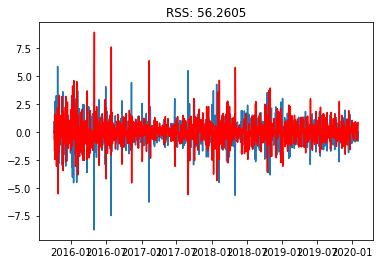

1 1 1


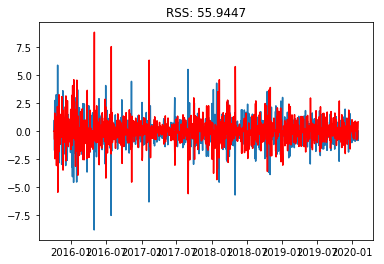

1 1 2


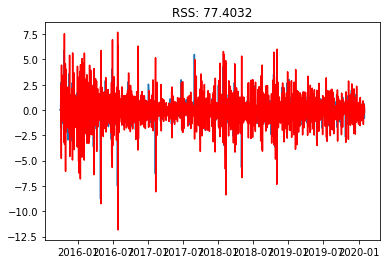

1 2 0


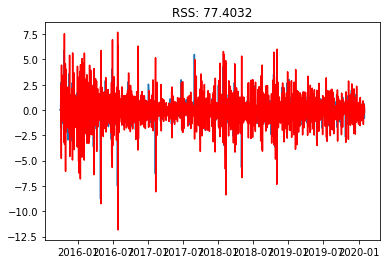

1 2 1


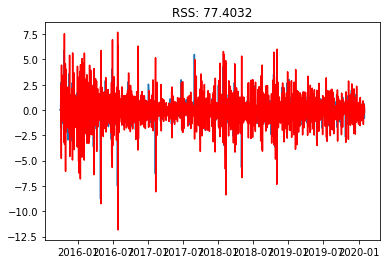

1 2 2


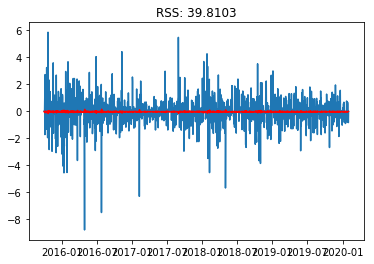

2 0 0
39.80300050241421


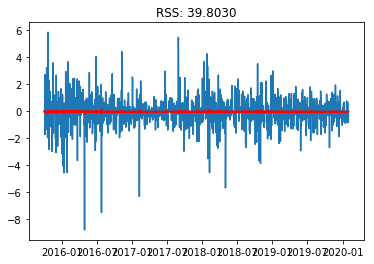

2 0 1


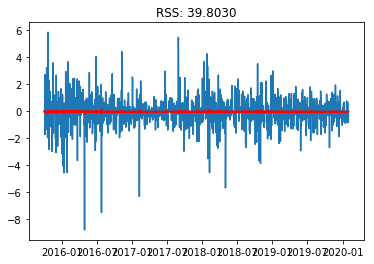

2 0 2


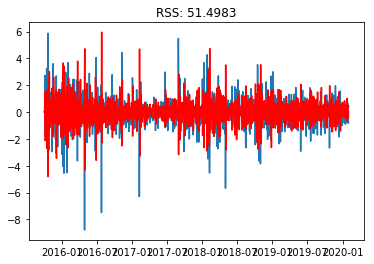

2 1 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


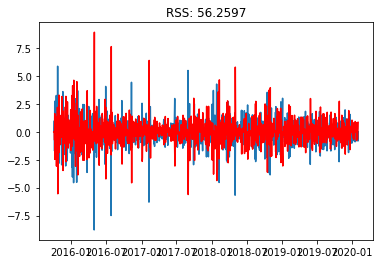

2 1 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


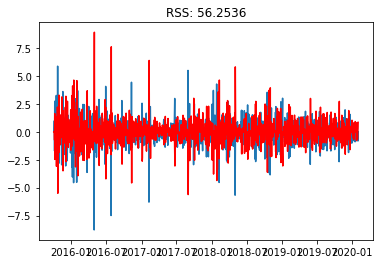

2 1 2


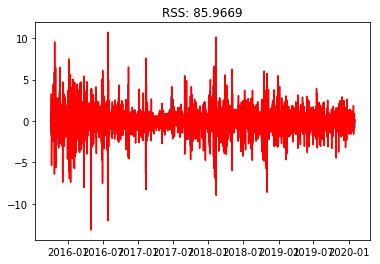

2 2 0


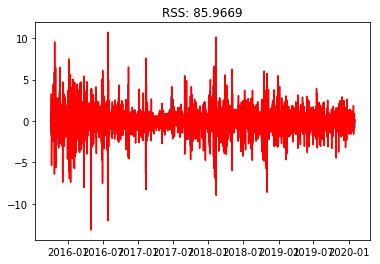

2 2 1


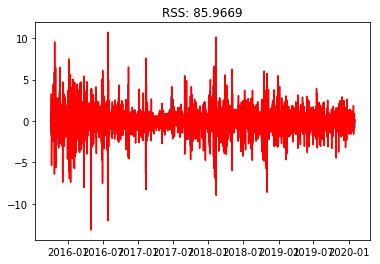

2 2 2
39.76366788217969


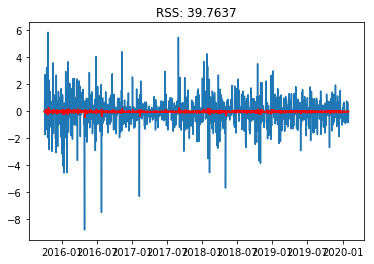

3 0 0
39.76314799069426


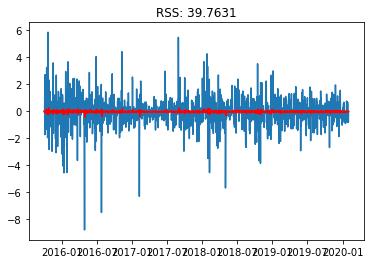

3 0 1
39.70862631245942


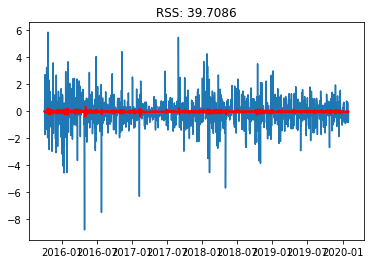

3 0 2


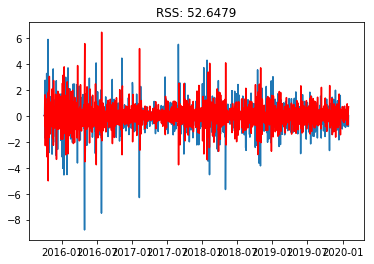

3 1 0


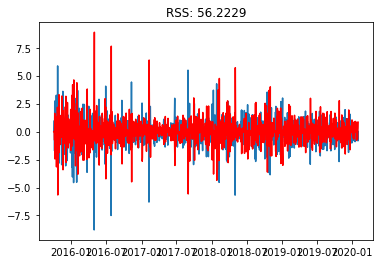

3 1 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


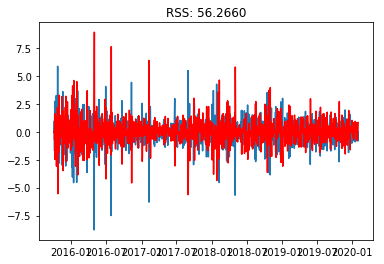

3 1 2


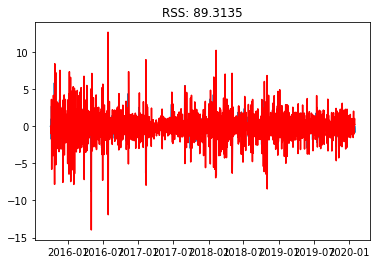

3 2 0


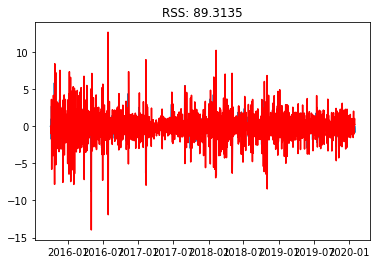

3 2 1


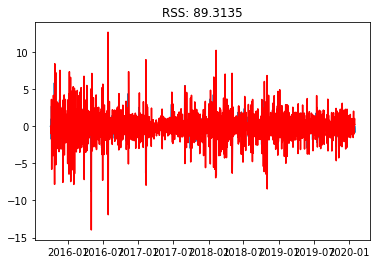

3 2 2


In [20]:
#Manually differenced data.
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(diff, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(diff)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(diff)

            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [21]:
#Manually differenced
differencedbestints = best_ints
print(differencedbestints)
print(loss_best)

[3, 0, 2]
39.70862631245942


432.89292772166147


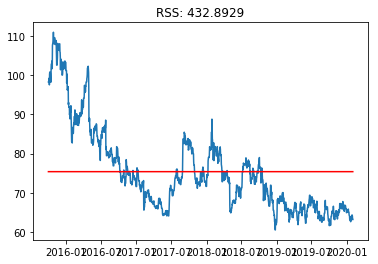

0 0 0
232.88539817837517


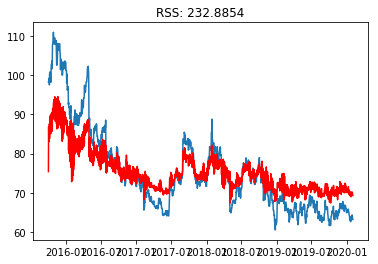

0 0 1
146.70361668918267


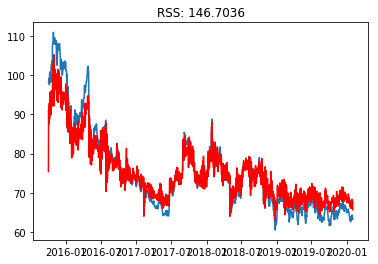

0 0 2


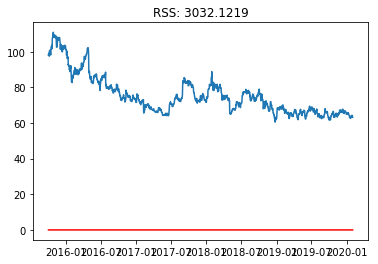

0 1 0


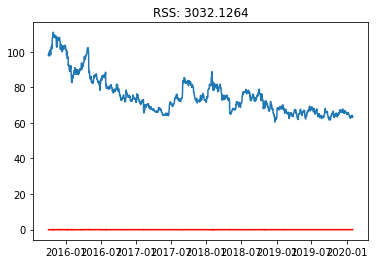

0 1 1


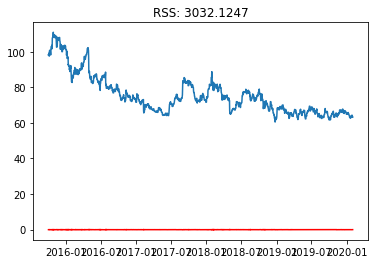

0 1 2


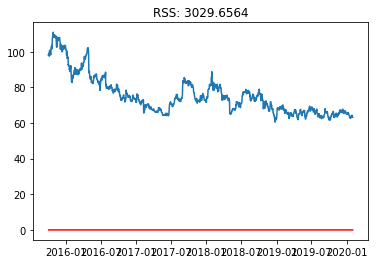

0 2 0


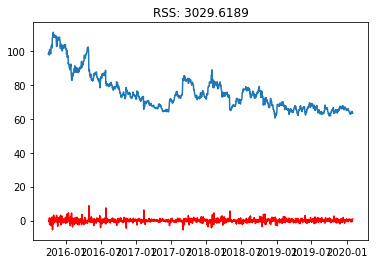

0 2 1


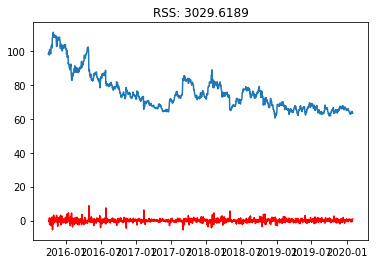

0 2 2
45.16727706627317


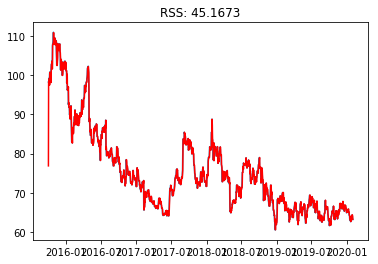

1 0 0
45.134440462797066


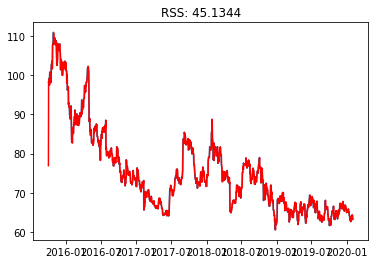

1 0 1


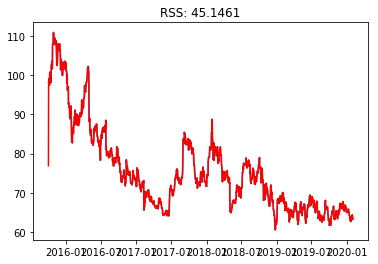

1 0 2


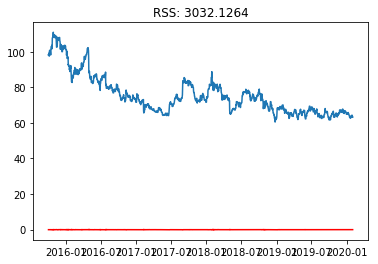

1 1 0


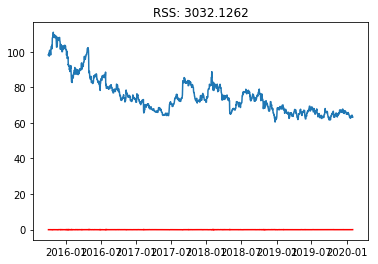

1 1 1


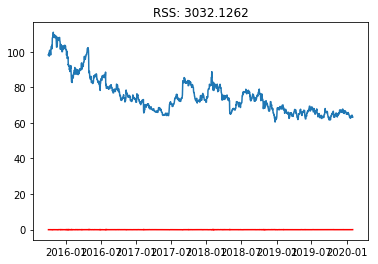

1 1 2


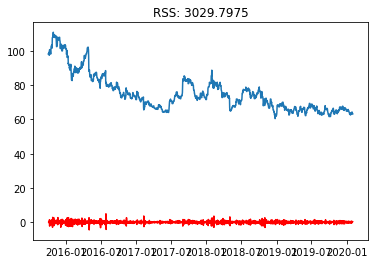

1 2 0


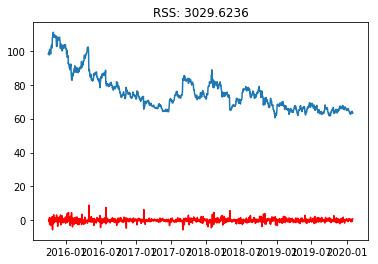

1 2 1


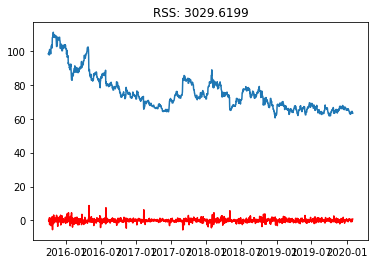

1 2 2
45.134026052306


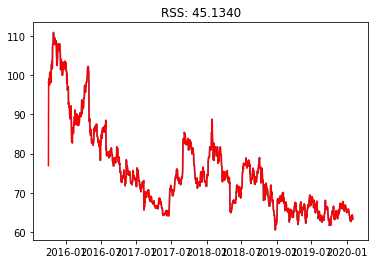

2 0 0


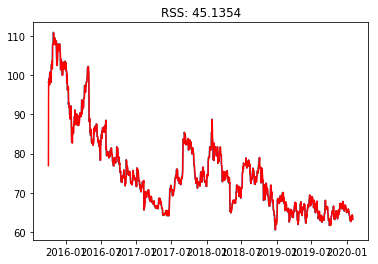

2 0 1
45.12897040457223


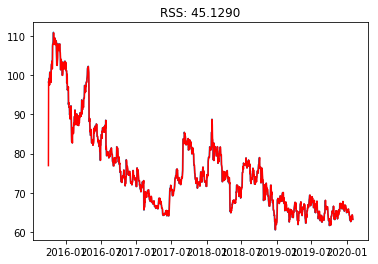

2 0 2


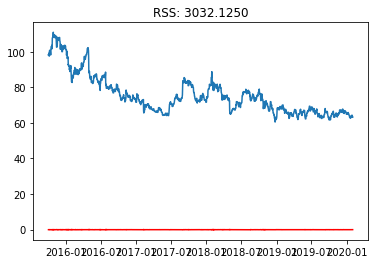

2 1 0


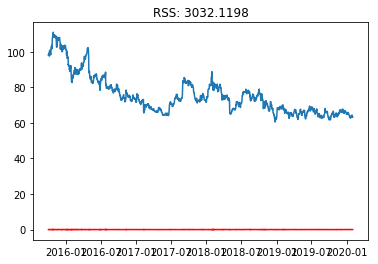

2 1 1


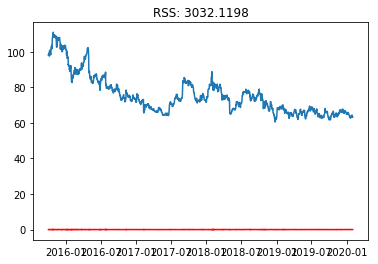

2 1 2


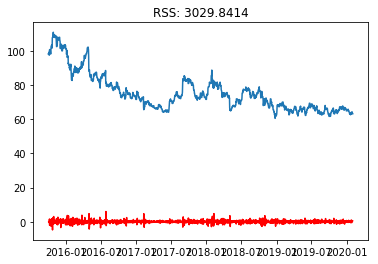

2 2 0


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


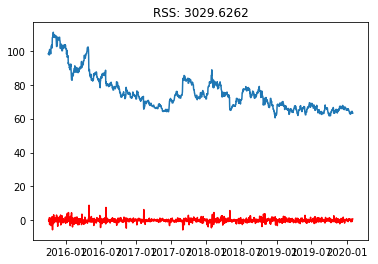

2 2 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


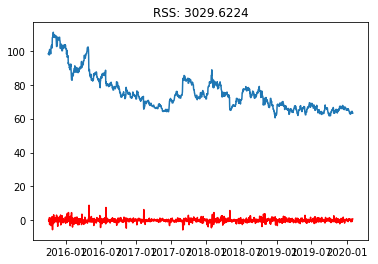

2 2 2


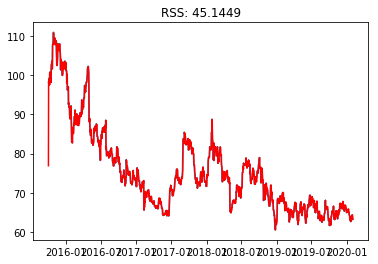

3 0 0


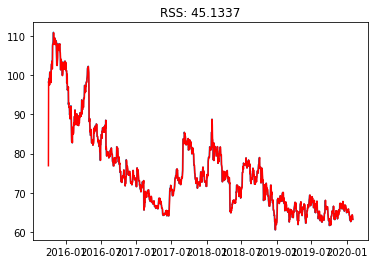

3 0 1
44.947911367584986


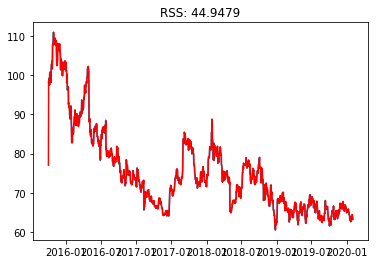

3 0 2


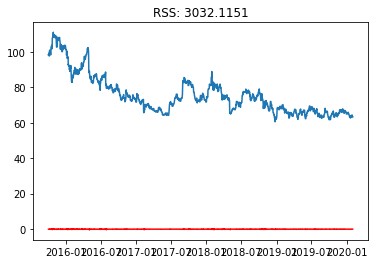

3 1 0


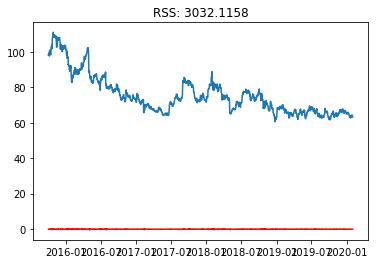

3 1 1


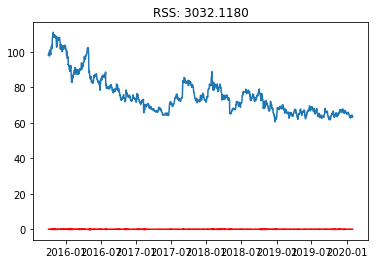

3 1 2


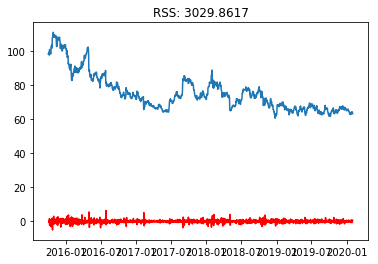

3 2 0


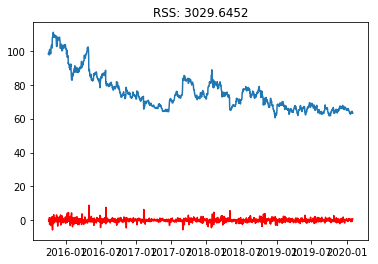

3 2 1


C:\Users\danie\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


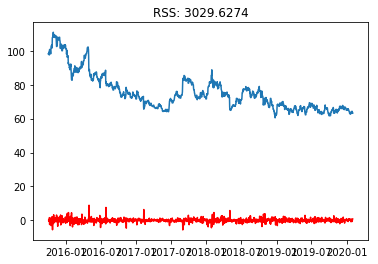

3 2 2


In [22]:
#Raw (not manually differenced) data.
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(price, order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(price)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            #Changed this from diff to price. Error on professor part?
#             x=x.join(diff)
            x=x.join(price)

            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            if loss < loss_best:
                print(loss)
                loss_best = loss
                best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [23]:
#Raw (not manually differenced) data.
rawbestints = best_ints
print(rawbestints)
print(loss_best)

[3, 0, 2]
44.947911367584986


 __DD__ Grid search chooses p=3, d=0, q = 2 for both. Apparently manual differencing improves our loss_best slightly better than not. Our rule says that we should be cautious of p and q canceling each other out. 

It's probably ok that the manually differenced chose d=0, however theenot manually differenced grid would require at least 1 based on rules and assumptions. (We are confident that we require differencing.)

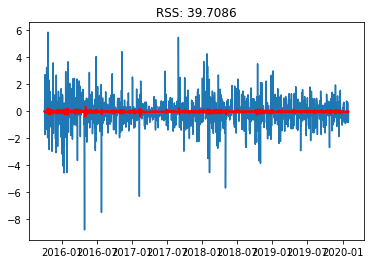

39.70862631245942


In [24]:
#Manually differenced
stock_price = diff.astype(float)

model = ARIMA(stock_price.dropna(), order=(3, 0, 2))  
results_ARIMA = model.fit(disp=-1)

plt.plot(stock_price)
plt.plot(results_ARIMA.fittedvalues, color='red')
x=pd.DataFrame(results_ARIMA.fittedvalues)
x=x.join(stock_price)
x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
loss=np.sqrt(x['out'].sum())
plt.title('RSS: %.4f'% loss)

plt.show()
print(loss)

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1584
Model:                     ARMA(3, 2)   Log Likelihood               -2243.974
Method:                       css-mle   S.D. of innovations              0.998
Date:                Sun, 01 Mar 2020   AIC                           4501.948
Time:                        14:38:26   BIC                           4539.522
Sample:                    10-02-2015   HQIC                          4515.907
                         - 02-01-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0222      0.026     -0.866      0.387      -0.072       0.028
ar.L1.Close     0.7141      0.185      3.857      0.000       0.351       1.077
ar.L2.Close    -0.7694      0.128     -6.025    

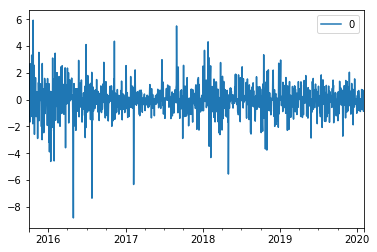

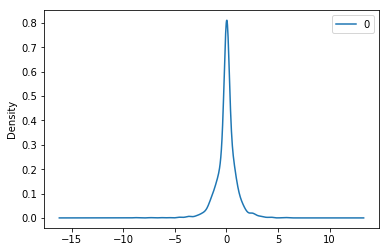

                 0
count  1584.000000
mean      0.000005
std       0.998032
min      -8.829465
25%      -0.302427
50%       0.028317
75%       0.326231
max       5.930208


In [25]:
#Manually differenced
print(results_ARIMA.summary())
# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

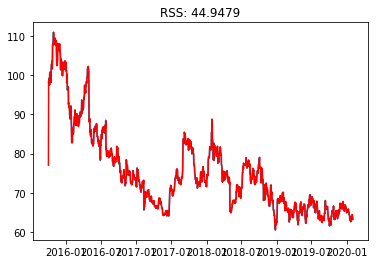

44.947911367584986


In [26]:
#Not manually differenced
stock_price = price.astype(float)

model = ARIMA(stock_price.dropna(), order=(3, 0, 2))  
results_ARIMA = model.fit(disp=-1)

plt.plot(stock_price)
plt.plot(results_ARIMA.fittedvalues, color='red')
x=pd.DataFrame(results_ARIMA.fittedvalues)
x=x.join(stock_price)
x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
loss=np.sqrt(x['out'].sum())
plt.title('RSS: %.4f'% loss)

plt.show()
print(loss)

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1585
Model:                     ARMA(3, 2)   Log Likelihood               -2244.931
Method:                       css-mle   S.D. of innovations              0.996
Date:                Sun, 01 Mar 2020   AIC                           4503.862
Time:                        14:38:54   BIC                           4541.441
Sample:                    10-01-2015   HQIC                          4517.823
                         - 02-01-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          77.0506      8.018      9.609      0.000      61.335      92.766
ar.L1.Close    -0.1054      0.006    -18.249      0.000      -0.117      -0.094
ar.L2.Close     0.1047      0.008     12.661    

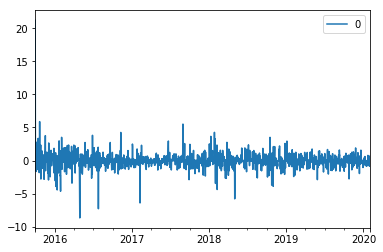

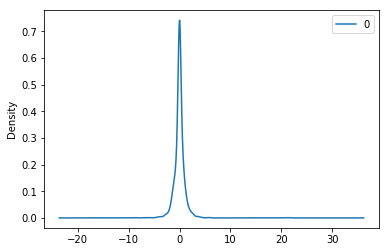

                 0
count  1585.000000
mean     -0.013084
std       1.129283
min      -8.676381
25%      -0.325912
50%      -0.003721
75%       0.316763
max      21.219402


In [27]:
#Not manually differenced
print(results_ARIMA.summary())
# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())